In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/data/nihaifeng/code/HeliosArtifact/simulator')
import utils

In [ ]:
# 文件路径
file_path = "/data/nihaifeng/log/star1/nohup/defragS_sdf.out"

# 初始化计数器
migrate_count = 0

# 打开文件并逐行读取
with open(file_path, "r", encoding="utf-8") as file:
	for line in file:
		# 检查 "MIGRATE" 是否在当前行中
		if "MIGRATE" in line:
			migrate_count += 1

# 输出结果
print(f"含有 'MIGRATE' 的行的数量: {migrate_count}")


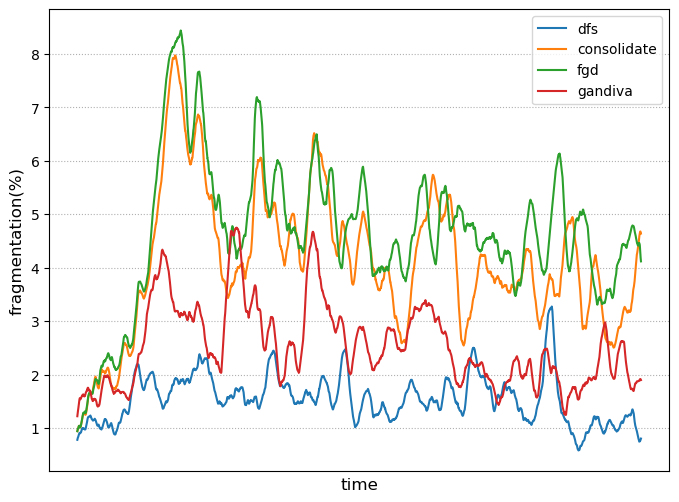

In [2]:
# schedulers = ["defragS_fifo","fifo_consolidate", "fifo_FGD", "gandiva_fifo"]
# labels = ["dfs-fifo", "consolidate-fifo", "fgd-fifo", "gandiva-fifo"]

schedulers = ["defragS_sdf", "sjf_consolidate", "sjf_FGD", "gandiva_sjf"]
labels = ["dfs", "consolidate", "fgd", "gandiva"]

log_dir = "/data/nihaifeng/log/test" 
saving = False
window_size = 60 * 24 * 1

fig = plt.figure(figsize=(8,6))
for idx, scheduler in enumerate(schedulers):
	df = pd.read_csv(log_dir+f'/Philly_{scheduler}/all/{scheduler}_all_seq.csv')
	y = df['fragmentation_ration']*100
	plt.plot(df['time'], y.rolling(window=window_size).mean(), label=labels[idx])

plt.xlabel('time', fontsize=12)
plt.xticks([])
plt.ylabel('fragmentation(%)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(linestyle=':')
plt.show()

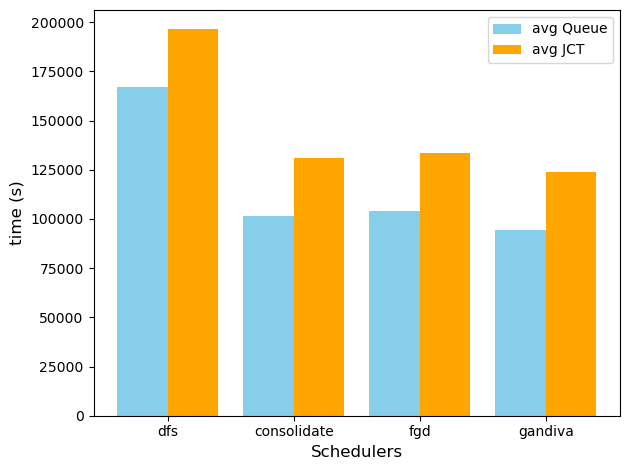

que_list:  [166821, 101400, 104171, 94304]
jct_list:  [196360, 130938, 133710, 123843]


In [3]:
que_list, jct_list = [], []
for scheduler in schedulers:
	df = pd.read_csv(log_dir+f'/Philly_{scheduler}/jct_avg.csv')
	jct_list.append(df.iloc[len(df)-1, 1])
	df = pd.read_csv(log_dir+f'/Philly_{scheduler}/que_avg.csv')
	que_list.append(df.iloc[len(df)-1, 1])
		

# 设置柱状图的宽度和位置
x_indices = np.arange(len(schedulers))  # x 轴位置
bar_width = 0.4  # 每个柱的宽度


# 绘制两组柱状图
plt.bar(x_indices - bar_width/2, que_list, bar_width, label='avg Queue', color='skyblue')
plt.bar(x_indices + bar_width/2, jct_list, bar_width, label='avg JCT', color='orange')

# 设置 x 轴标签
plt.xticks(x_indices, labels)
# plt.yticks([])

# 添加标题和坐标轴标签
plt.xlabel("Schedulers", fontsize=12)
plt.ylabel("time (s)", fontsize=12)

# 添加图例
plt.legend()

# 显示图表
plt.tight_layout()
plt.show()
print("que_list: ", que_list)
print("jct_list: ", jct_list)

In [4]:
tmp = que_list.copy()
tmp.sort()
print(tmp)
print((tmp[1]-tmp[0])/tmp[1])

[4248, 4657, 4818, 5734]
0.08782477990122396


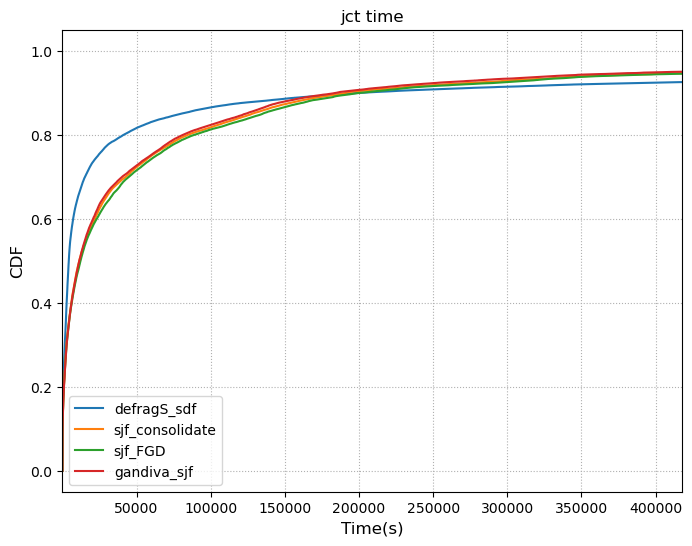

In [4]:
data_type = "jct"

fig = plt.figure(figsize=(8,6))
for idx, scheduler in enumerate(schedulers):
	df = pd.read_csv(log_dir+f'/Philly_{scheduler}/all/{scheduler}_all_log.csv')
	y = df[data_type]
	sorted_y = np.sort(y)
	cdf = np.arange(1, len(sorted_y) + 1) / len(sorted_y)
	plt.plot(sorted_y, cdf, label=scheduler)

x_min = np.min(sorted_y)
x_max = np.percentile(sorted_y, 95)  # 选择中位数作为最大范围
plt.xlim(x_min, x_max)  # 设置 x 轴范围

plt.title(f"{data_type} time")
plt.xlabel('Time(s)', fontsize=12)
plt.ylabel('CDF', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(linestyle=':')
plt.show()

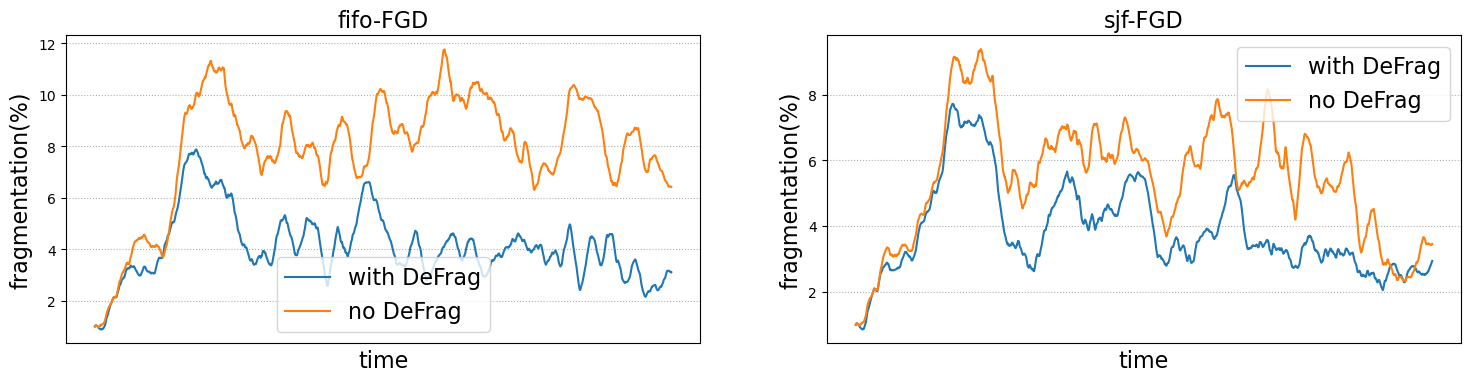

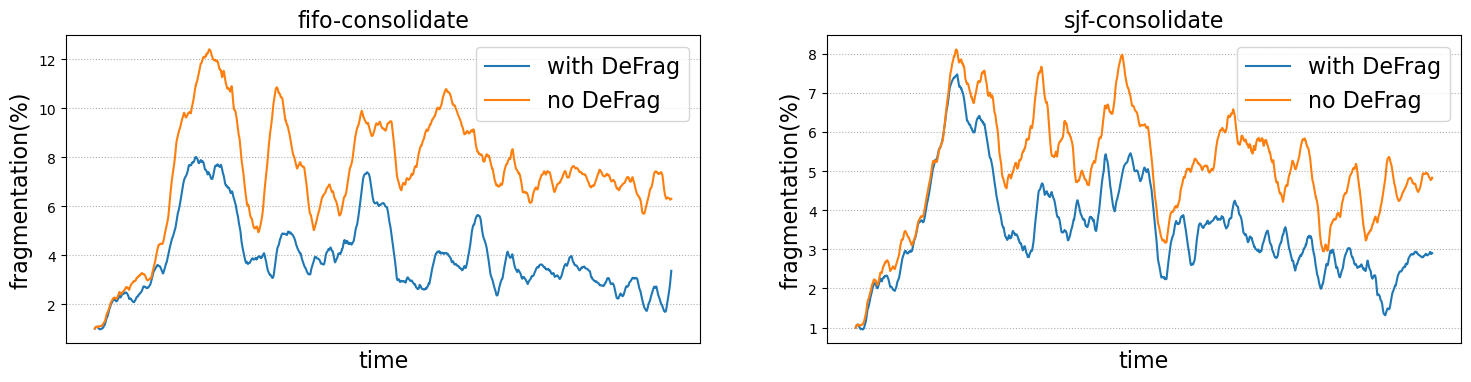

In [9]:
scheduler_ls = ['fifo', 'sjf'] 
placer_ls = ['FGD', 'consolidate']
log_dir = "/data/nihaifeng/log/test/"
saving = True
window_size = 60 * 24

for placer in placer_ls:
	fig, axes = plt.subplots(1, len(scheduler_ls), figsize=(18,4))
	axes = axes.flatten() 
	for idx, scheduler in enumerate(scheduler_ls):
		ax = axes[idx]
		df = pd.read_csv(log_dir+f'/deFrag/Philly_{placer}/all/{scheduler}_{placer}_all_seq.csv')
		y = df['fragmentation_ration']*100
		ax.plot(df['time'], y.rolling(window=window_size).mean(), label=f"with DeFrag")

		df = pd.read_csv(log_dir + f'/noDeFrag/Philly_{placer}/all/{scheduler}_{placer}_all_seq.csv')
		y = df['fragmentation_ration']*100
		ax.plot(df['time'], y.rolling(window=window_size).mean(), label=f"no DeFrag")

		ax.set_title(f'{scheduler}-{placer}', fontsize=16)
		ax.set_xlabel('time', fontsize=16)
		ax.set_xticks([])
		ax.set_ylabel('fragmentation(%)', fontsize=16)
		ax.legend(loc='best', fontsize=16)
		ax.grid(linestyle=':')

	if saving:
		plt.savefig(log_dir+f'/figures/{placer}_frag.pdf', bbox_inches="tight", dpi=600)
	else:
		plt.show()

对比不同pro下Queue时间累积分布

分析加入碎片整理后，碎片率无法下降的原因

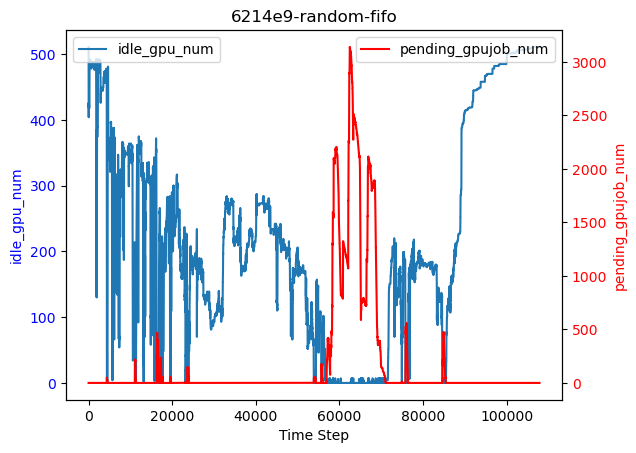

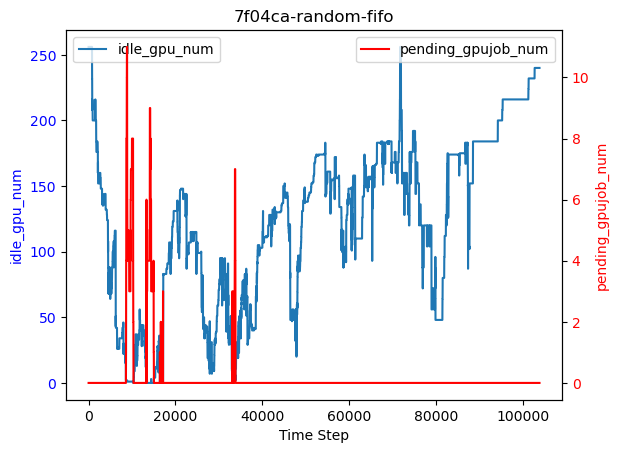

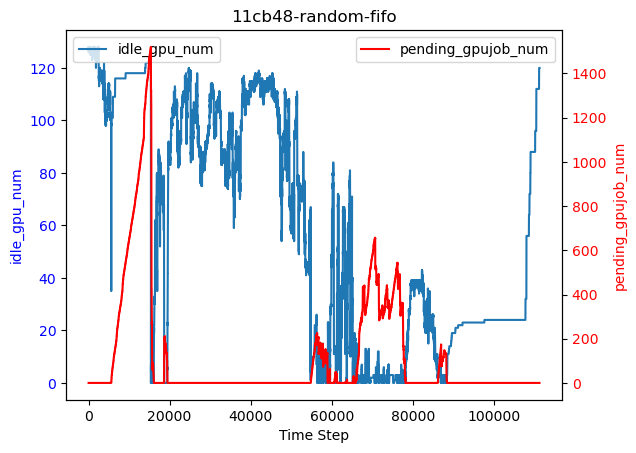

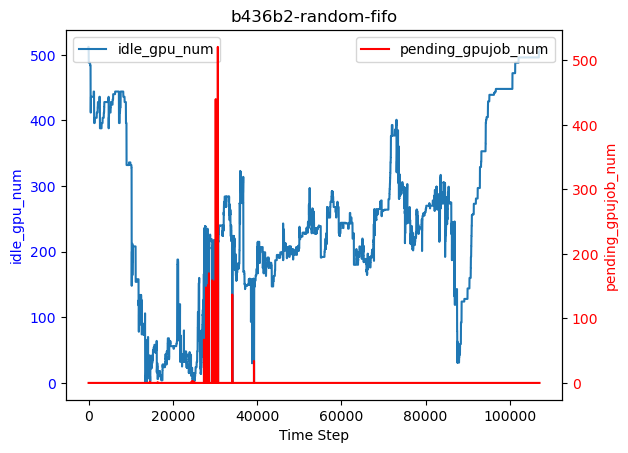

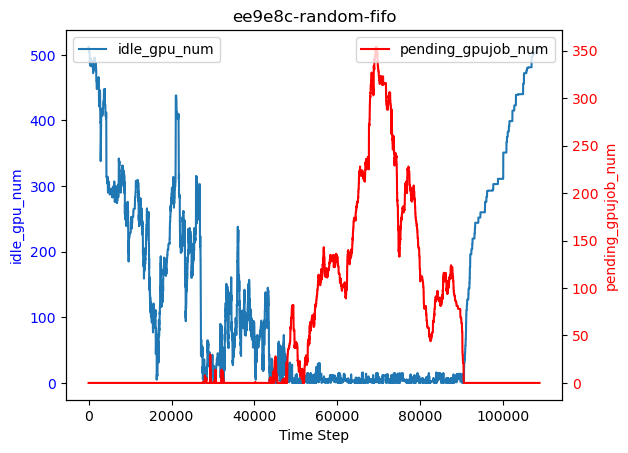

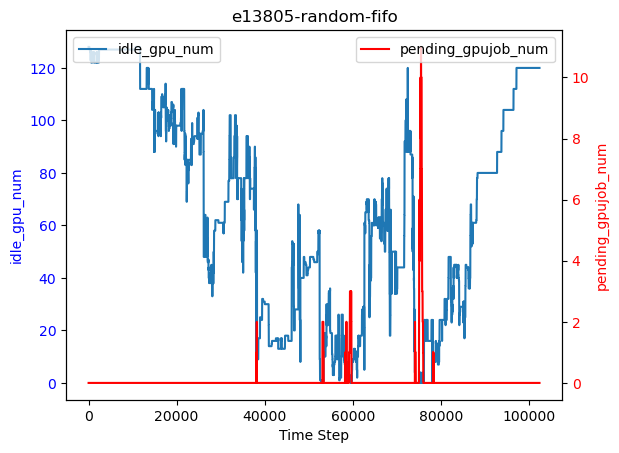

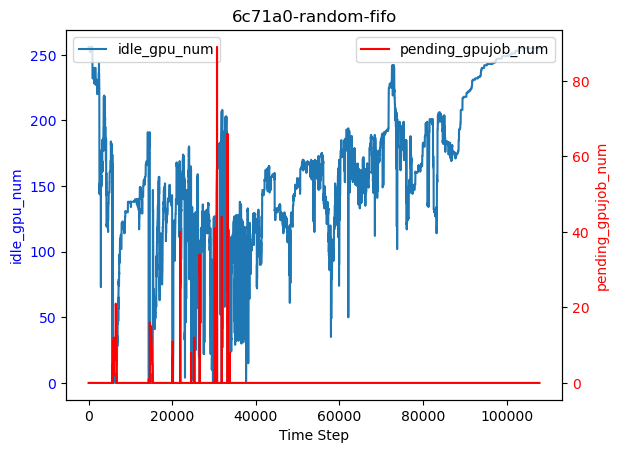

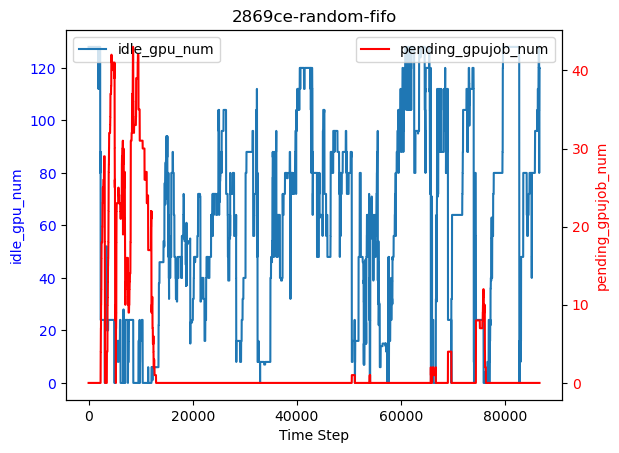

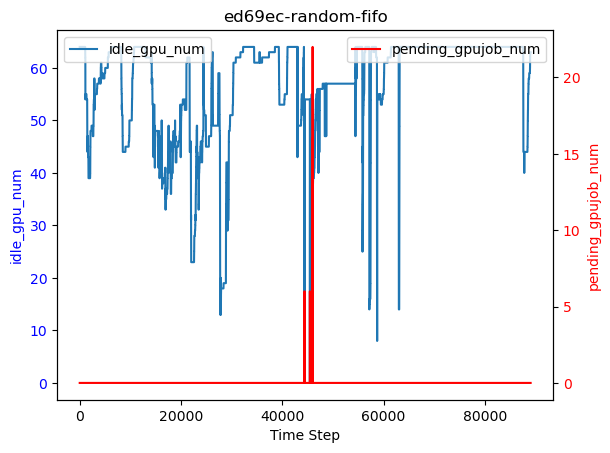

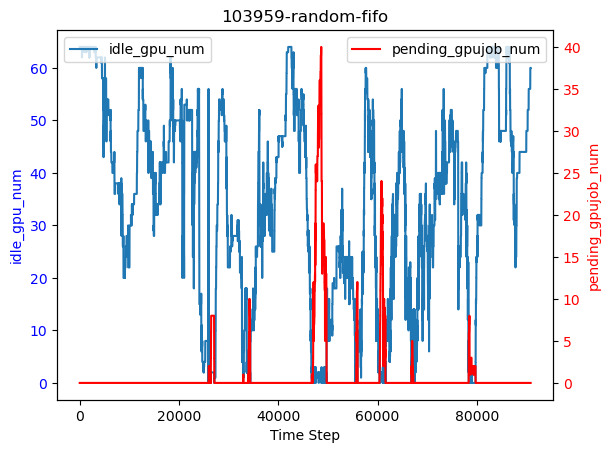

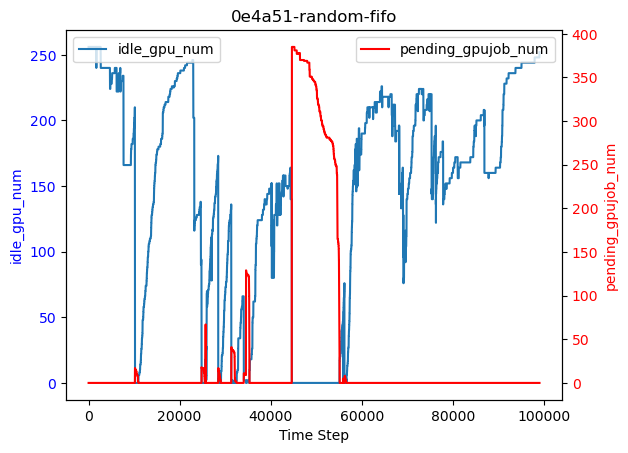

In [27]:
log_dir = "/data/nihaifeng/log"
vc_ls = pd.read_pickle('simulator/data/Philly/vc_dict_homo.pkl')
placer = 'random'
scheduler = 'fifo'
need_smoothing = False
window_size = 60*15

for vc in vc_ls:
	df = pd.read_csv(log_dir + f'/deFrag_VS_noDeFrag/frag_2/noDeFrag/Philly_{placer}/{vc}/{scheduler}_{placer}_{vc}_seq.csv')
	
	# 创建图形和主轴
	fig, ax1 = plt.subplots()

	# 绘制 idle_gpu_num
	data_name = 'idle_gpu_num'
	if need_smoothing:
		ax1.plot(df[data_name].rolling(window=window_size).mean(), label=data_name)
	else:
		ax1.plot(df[data_name], label=data_name)
	ax1.set_xlabel('Time Step')
	ax1.set_ylabel(data_name, color='b')
	ax1.tick_params(axis='y', labelcolor='b')

	# 创建共享 X 轴的第二个 Y 轴
	ax2 = ax1.twinx()
	data_name = 'pending_gpujob_num'
	if need_smoothing:
		ax2.plot(df[data_name].rolling(window=window_size).mean(), color='r', label=data_name)
	else:
		ax2.plot(df[data_name], color='r', label=data_name)
	ax2.set_ylabel(data_name, color='r')
	ax2.tick_params(axis='y', labelcolor='r')

	# 设置图表标题
	plt.title(f"{vc}-{placer}-{scheduler}")

	# 添加图例
	ax1.legend(loc='upper left')
	ax2.legend(loc='upper right')

	# 显示图形
	plt.show()

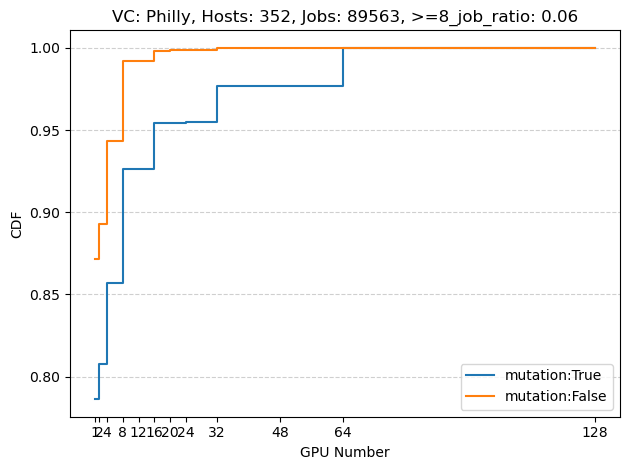

In [5]:
###### jog req GPUs CDF 
trace_dir = '/data/nihaifeng/code/HeliosArtifact/simulator/data/Philly'
vc_dict = pd.read_pickle(trace_dir+'/vc_dict_homo.pkl')
trace_range = ('2017-10-01 00:00:00', '2017-11-30 23:59:00')

for muation in [True, False]:
	trace_df, _ = utils.trace_philly_process(trace_dir, trace_range, vc_dict, muation)
	gpu_num_type = trace_df['gpu_num'].unique()
	gpu_num_type = sorted(gpu_num_type)
	y = [len(trace_df[trace_df['gpu_num'] == x]) for x in gpu_num_type]
	# 计算 CDF
	y_cumsum = np.cumsum(y)  # 累加频率
	y_cdf = y_cumsum / sum(y)  # 归一化
	# 绘制 CDF 图
	plt.step(gpu_num_type, y_cdf, where='post', label=f'mutation:{muation}')

plt.xlabel('GPU Number')
plt.ylabel('CDF')
plt.title(f"VC: Philly, Hosts: {sum(vc_dict.values())}, Jobs: {trace_df.shape[0]}, >=8_job_ratio: {sum([y[i] for i in range(len(gpu_num_type)) if gpu_num_type[i] >= 8])/trace_df.shape[0]:.2f}")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(gpu_num_type)  # 设置x轴刻度为GPU数量
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
trace_dir = '/data/nihaifeng/code/HeliosArtifact/simulator/data/Philly'
vc_dict = pd.read_pickle(trace_dir+'/vc_dict_homo.pkl')

trace_range = ('2017-10-01 00:00:00', '2017-11-30 23:59:00')
trace_df, start_ts = utils.trace_philly_process(trace_dir, trace_range, vc_dict, need_mutation=True)
for vc_name, host_num in vc_dict.items():
	vc_df = trace_df[trace_df['vc'] == vc_name]
	gpu_num_type = vc_df['gpu_num'].unique()
	gpu_num_type = sorted(gpu_num_type)
	y = [len(vc_df[vc_df['gpu_num'] == x]) for x in gpu_num_type]
	
	plt.bar(gpu_num_type, y, color='skyblue', edgecolor='black', alpha=0.7)
	plt.xlabel('GPU Number')
	plt.ylabel('Job number')
	plt.title(f"VC:{vc_name}, Hosts:{host_num}, Jobs:{vc_df.shape[0]}, >=8_job_ratio:{sum([y[i] for i in range(len(gpu_num_type)) if gpu_num_type[i] >= 8])/vc_df.shape[0]:.2f}")
	plt.grid(axis='y', linestyle='--', alpha=0.6)
	plt.xticks(gpu_num_type)  # 设置x轴刻度为GPU数量
	plt.tight_layout()
	plt.show()

# total log
gpu_num_type = trace_df['gpu_num'].unique()
gpu_num_type = sorted(gpu_num_type)
y = [len(trace_df[trace_df['gpu_num'] == x]) for x in gpu_num_type]

plt.bar(gpu_num_type, y, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('GPU Number')
plt.ylabel('Job number')
plt.title(f"VC:Philly, Hosts:{sum(vc_dict.values())}, Jobs:{trace_df.shape[0]}, >=8_job_ratio:{sum([y[i] for i in range(len(gpu_num_type)) if gpu_num_type[i] >= 8])/trace_df.shape[0]:.2f}")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(gpu_num_type)  # 设置x轴刻度为GPU数量
plt.tight_layout()
plt.show()